#Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

#Generate mock customer data

In [2]:
np.random.seed(42)
num_customers = 2000
data = {

    'CustomerID': [f'CUST{1000+i}' for i in range(num_customers)],

    'Gender': np.random.choice(['Male', 'Female'], num_customers, p=[0.5, 0.5]),

    'SeniorCitizen': np.random.choice([0, 1], num_customers, p=[0.84, 0.16]),

    'Partner': np.random.choice(['Yes', 'No'], num_customers, p=[0.48, 0.52]),

    'Dependents': np.random.choice(['Yes', 'No'], num_customers, p=[0.3, 0.7]),

    'Tenure': np.random.randint(1, 73, num_customers), # Months

    'PhoneService': np.random.choice(['Yes', 'No'], num_customers, p=[0.9, 0.1]),

    'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], num_customers, p=[0.42, 0.48, 0.1]),

    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], num_customers, p=[0.34, 0.44, 0.22]),

    'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.28, 0.50, 0.22]),

    'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),

    'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),

    'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.29, 0.49, 0.22]),

    'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.38, 0.40, 0.22]),

    'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.39, 0.39, 0.22]),

    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], num_customers, p=[0.55, 0.24, 0.21]),

    'PaperlessBilling': np.random.choice(['Yes', 'No'], num_customers, p=[0.59, 0.41]),

    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], num_customers, p=[0.34, 0.23, 0.22, 0.21]),

    'MonthlyCharges': np.random.normal(loc=65, scale=30, size=num_customers).clip(18, 120).round(2),

}

df_customers = pd.DataFrame(data)

In [3]:
# Generate TotalCharges based on Tenure and MonthlyCharges with some noise
df_customers['TotalCharges'] = (df_customers['Tenure'] * df_customers['MonthlyCharges'] * np.random.uniform(0.95, 1.05, num_customers)).round(2)

# Make some TotalCharges empty for realism (e.g., new customers with 0 tenure)
df_customers.loc[df_customers['Tenure'] == 1, 'TotalCharges'] = df_customers['MonthlyCharges']

# Get the indices where Tenure < 3 and randomly select 1% of customers
idx_tenure_less_than_3 = df_customers[df_customers['Tenure'] < 3].index
indices_to_nan = np.random.choice(idx_tenure_less_than_3, size=int(num_customers*0.01), replace=False)

df_customers.loc[indices_to_nan, 'TotalCharges'] = np.nan


# Simulate Churn (more likely for month-to-month, higher charges, lower tenure)
churn_probability = 0.1 \
    + 0.15 * (df_customers['Contract'] == 'Month-to-month') \
    + 0.1 * (df_customers['InternetService'] == 'Fiber optic') \
    + 0.001 * (df_customers['MonthlyCharges'] - 65) \
    - 0.002 * (df_customers['Tenure'] - 36) \
    + 0.1 * (df_customers['OnlineSecurity'] == 'No') \
    + 0.1 * (df_customers['TechSupport'] == 'No')



churn_probability = np.clip(churn_probability, 0.01, 0.99)
df_customers['Churn'] = np.random.binomial(1, churn_probability, num_customers).astype(str)
df_customers['Churn'] = df_customers['Churn'].replace({'1': 'Yes', '0': 'No'})

# Replace 'No phone service' and 'No internet service' for consistency
for col in ['MultipleLines']:
    df_customers[col] = df_customers.apply(lambda row: 'No' if row['PhoneService'] == 'No' else row[col], axis=1)
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df_customers[col] = df_customers.apply(lambda row: 'No' if row['InternetService'] == 'No' else row[col], axis=1)

In [4]:
# Save to CSV
df_customers.to_csv('telecom_churn_mock_data.csv', index=False)
df_customers.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST1000,Male,0,No,No,30,Yes,Yes,No,No,...,No,No,No,No,Month-to-month,No,Bank transfer (automatic),69.55,2047.01,Yes
1,CUST1001,Female,0,No,Yes,11,Yes,Yes,Fiber optic,No internet service,...,No,No internet service,No,No internet service,Month-to-month,Yes,Electronic check,48.08,522.42,No
2,CUST1002,Female,1,No,No,17,No,No,Fiber optic,No,...,No,No,Yes,No,Two year,No,Electronic check,36.56,610.07,No
3,CUST1003,Female,0,Yes,No,26,Yes,No,No,No,...,No,No,No,No,One year,Yes,Bank transfer (automatic),79.72,2159.26,No
4,CUST1004,Male,0,Yes,Yes,23,Yes,No,Fiber optic,No internet service,...,No,Yes,No,Yes,Month-to-month,Yes,Mailed check,70.42,1672.56,No


#Exploratory Data Analysis (EDA)

In [9]:
print("Dataset Shape:", df_customers.shape)

Dataset Shape: (2000, 21)


In [10]:
print("\n Data Types:\n", df_customers.dtypes)


 Data Types:
 CustomerID           object
Gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
Tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [7]:
print("\n Unique Values per Column:\n", df_customers.nunique())


 Unique Values per Column:
 CustomerID          2000
Gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
Tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1681
TotalCharges        1977
Churn                  2
dtype: int64


In [8]:
print("\n Missing Values per Column:\n", df_customers.isnull().sum())


 Missing Values per Column:
 CustomerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        20
Churn                0
dtype: int64


In [9]:
print("\n Target Variable Distribution:\n", df_customers["Churn"].value_counts())


 Target Variable Distribution:
 Churn
No     1354
Yes     646
Name: count, dtype: int64


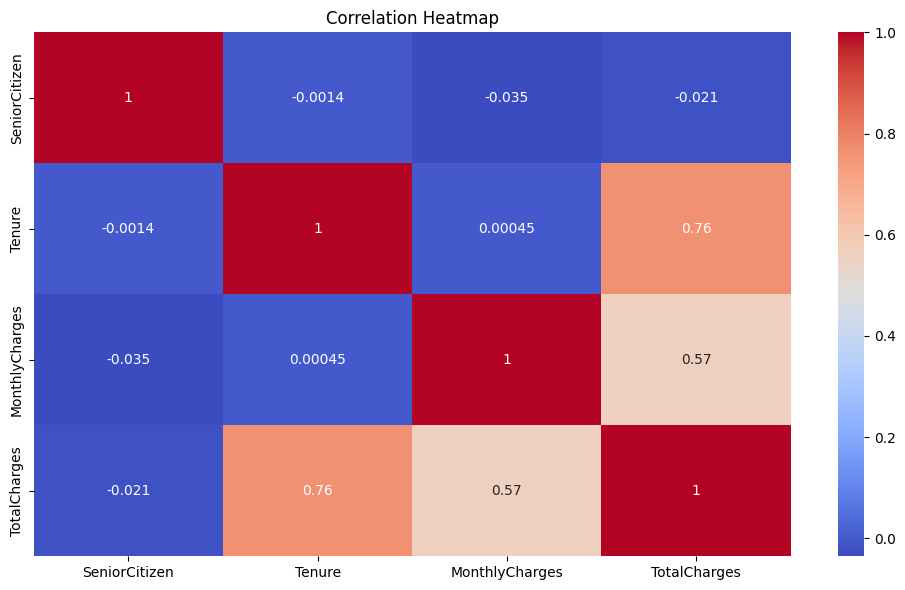

In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_customers.select_dtypes(include=["float64", "int64"]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

#Handle Missing Data

In [11]:
# Impute TotalCharges (20 missing) with median
df_customers["TotalCharges"].fillna(df_customers["TotalCharges"].median(), inplace=True)

# Confirm all missing handled
print("\n Missing values after imputation:\n", df_customers.isnull().sum())


 Missing values after imputation:
 CustomerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


/tmp/ipython-input-11-4166425835.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_customers["TotalCharges"].fillna(df_customers["TotalCharges"].median(), inplace=True)


#Encode Categorical Variables

In [5]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of dataframe
df_customers_encoded = df_customers.copy()

# Label encode object-type columns except CustomerID
label_encoders = {}
categorical_cols = df_customers_encoded.select_dtypes(include="object").columns.drop("CustomerID")

for col in categorical_cols:
    le = LabelEncoder()
    df_customers_encoded[col] = le.fit_transform(df_customers_encoded[col])
    label_encoders[col] = le

# Drop CustomerID (not useful)
df_customers_encoded.drop(columns=["CustomerID"], inplace=True)

# Preview encoded dataset
df_customers_encoded.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,0,30,1,2,2,0,0,0,0,0,0,0,0,0,69.55,2047.01,1
1,0,0,0,1,11,1,2,1,1,1,0,1,0,1,0,1,2,48.08,522.42,0
2,0,1,0,0,17,0,0,1,0,2,0,0,2,0,2,0,2,36.56,610.07,0
3,0,0,1,0,26,1,0,2,0,0,0,0,0,0,1,1,0,79.72,2159.26,0
4,1,0,1,1,23,1,0,1,1,0,0,2,0,2,0,1,3,70.42,1672.56,0


#Feature Engineering

In [12]:
#Create new features
df_customers_encoded["AvgMonthlyCharge"] = df_customers_encoded["TotalCharges"] / df_customers_encoded["Tenure"].replace(0, 1)

In [6]:
# Select relevant features for model training
# Target variable
target = df_customers_encoded["Churn"]

# Feature set (drop target variable)
features = df_customers_encoded.drop(columns=["Churn", "Gender"])

# Show resulting feature columns
features.columns.tolist(), features.shape

(['SeniorCitizen',
  'Partner',
  'Dependents',
  'Tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges'],
 (2000, 18))

In [15]:
# Select Features
selected_features = [
    'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
    'MonthlyCharges', 'AvgMonthlyCharge'
]

X = df_customers_encoded[selected_features]
y = df_customers_encoded["Churn"]

# Train-test split + Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10]}),
    "Random Forest": (RandomForestClassifier(random_state=42), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}),
    "SVM": (SVC(probability=True), {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']})
}


 Best Model: Gradient Boosting → AUC: 0.5911


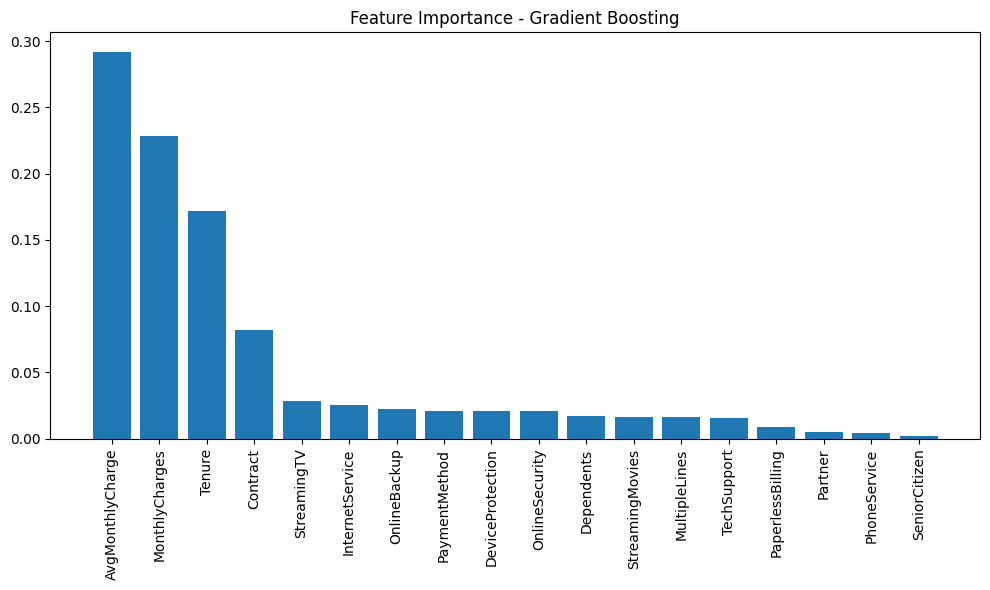

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Impute missing values in X_train and X_test before scaling
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


# Train-test split + Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)


results = {}
for name, (model, param_grid) in models.items():
    grid = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Model": best_model
    }

# Best model selection
best_model_name = max(results, key=lambda k: results[k]["ROC AUC"])
best_model = results[best_model_name]["Model"]
print(f"\n Best Model: {best_model_name} → AUC: {results[best_model_name]['ROC AUC']:.4f}")
# Feature importance
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance - {best_model_name}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [selected_features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [31]:
#  Top 10 features
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = [(selected_features[i], importances[i]) for i in indices[:10]]

    print("\n Top 10 Features Driving Customer Churn (by Importance):\n")
    for rank, (feature, importance) in enumerate(top_features, start=1):
        print(f"{rank:>2}. {feature:25} → Importance: {importance:.4f}")
else:
    print(" The best model does not support feature_importances_ (e.g., SVM or LogisticRegression).")



 Top 10 Features Driving Customer Churn (by Importance):

 1. AvgMonthlyCharge          → Importance: 0.2920
 2. MonthlyCharges            → Importance: 0.2287
 3. Tenure                    → Importance: 0.1717
 4. Contract                  → Importance: 0.0820
 5. StreamingTV               → Importance: 0.0283
 6. InternetService           → Importance: 0.0256
 7. OnlineBackup              → Importance: 0.0226
 8. PaymentMethod             → Importance: 0.0212
 9. DeviceProtection          → Importance: 0.0212
10. OnlineSecurity            → Importance: 0.0210


In [32]:
# Summary table
summary = pd.DataFrame({k: {
    "Accuracy": v["Accuracy"],
    "Precision": v["Precision"],
    "Recall": v["Recall"],
    "F1 Score": v["F1 Score"],
    "ROC AUC": v["ROC AUC"]
} for k, v in results.items()}).T

print("\n Model Evaluation Summary:")
print(summary.round(4))


 Model Evaluation Summary:
                     Accuracy  Precision  Recall  F1 Score  ROC AUC
Logistic Regression    0.6825     0.7500  0.0233    0.0451   0.5650
Random Forest          0.6525     0.3611  0.1008    0.1576   0.5740
Gradient Boosting      0.6550     0.4182  0.1783    0.2500   0.5911
SVM                    0.6225     0.3922  0.3101    0.3463   0.5251
